In [1]:
import torch.nn as nn
import torch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from data.dataloader import data_generator_real_data, data_generator_2types
from models.losses import loss_function_portfolio
from utils.utils import reconstruct_cov

In [4]:
from data.real_dataloader import real_data_pipeline

In [5]:
from models.gru_denoiser import BiGRUSpectralDenoiser

In [6]:
from training.trainer import Trainer

## NN

### Training loop on Real Data

In [7]:
model_real_data = BiGRUSpectralDenoiser(hidden_size=512) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

In [8]:
batch_size = 300
n_stocks = 200
T = 50

dataset = real_data_pipeline(
    batch_size,
    date_bounds=('1995-01-01','2015-01-01'),
    n_days_out = T+10,
    n_days_in = T,
    shift = 0,
    n_stocks = n_stocks,
    market_cap_range = (1000, 3000),
    sequential = False,
    return_generator = False,
)

In [9]:
real_data_trainer = Trainer(
    model=model_real_data, is_train_on_real_data = True, loss_function=loss_function_portfolio, data_generator=data_generator_real_data, lr = 5e-4, weight_decay=1e-6,
    batch_size=300, epochs=50, N_min=n_stocks, N_max=n_stocks, T_min=T, T_max=T, log_interval=10, accumulate_steps=5, dataset=dataset
)
# need to epochs to be big when there is lot of choise for N and T 
# need for big batch_size when df is big
losses_real_data = real_data_trainer.train()

Starting training for 50 epochs…
Epoch 10/50 — loss: -0.000830
Epoch 20/50 — loss: -0.000458
Epoch 30/50 — loss: -0.000286
Epoch 40/50 — loss: 0.000169
Epoch 50/50 — loss: -0.000697
Training complete.


identified 1 major problem of divergence : 
- when T and N are changing, loss Is not converging


In [10]:
# save the model
torch.save(model_real_data.state_dict(), "models/spectral_denoiser_model_real_data.pth")

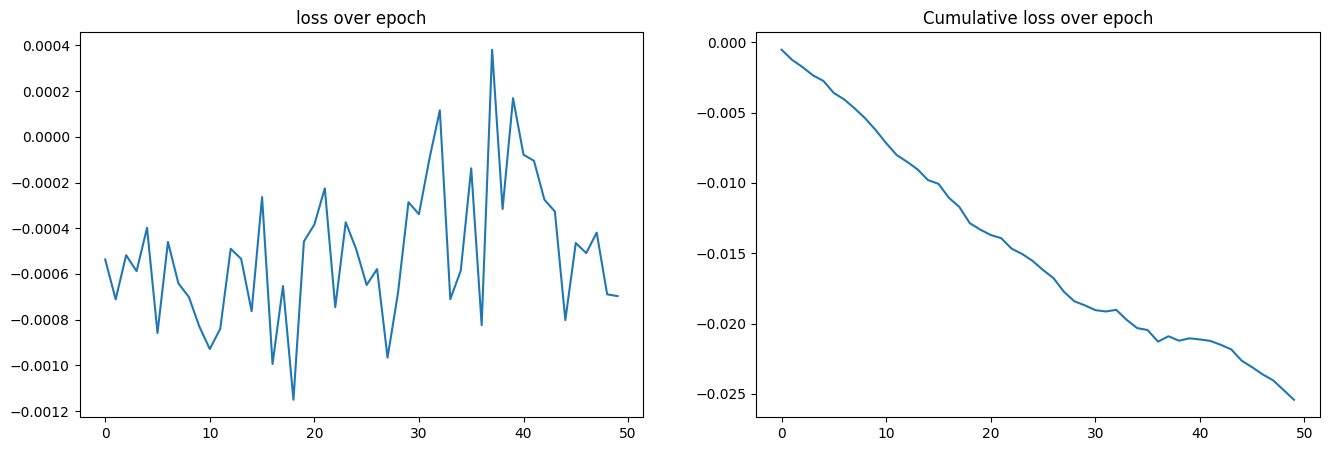

In [11]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses_real_data)
plt.title("loss over epoch")
plt.subplot(1,2,2)
plt.plot(np.cumsum(losses_real_data))
plt.title("Cumulative loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

we have to stop after the slow down of deacrese. otherwise we might face overfitting

In [12]:
state_dict_real_data = torch.load("models/spectral_denoiser_model_real_data.pth")
model_real_data.load_state_dict(state_dict_real_data)
model_real_data.eval()

BiGRUSpectralDenoiser(
  (gru): GRU(6, 512, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (activation): Softplus(beta=1.0, threshold=20.0)
)

### out of sample comparaison 1

In [13]:
batch_size_oos_1 = 25
N_list_test_1 = [20, 40, 60, 80, 100, 120, 140, 160, 180,200,220]
T_list_test_1 = [20, 40,60, 80, 100, 120, 150, 180, 200, 220, 240, 260, 280, 300]

In [14]:
losses_value = []

In [15]:
dataset = real_data_pipeline(
    25,
    date_bounds=('1995-01-01','2015-01-01'),
    n_days_out = T+10,
    n_days_in = T,
    shift = 0,
    n_stocks = n_stocks,
    market_cap_range = (1000, 3000),
    sequential = False,
    return_generator = False,
)

In [16]:
for n in N_list_test_1:
    for t in T_list_test_1:
        input_seq, Q_emp_oos_i, Sigma_true_oos_i, T_t = next(data_generator_real_data(N_min=n, N_max=n, T_min=t, T_max=t, dataset=dataset))
        lam_pred_test_i = model_real_data(input_seq)
        losses_value.append(loss_function_portfolio(lam_pred_test_i, Q_emp_oos_i, Sigma_true_oos_i, T_t).item())

In [17]:
# meshing
loss_grid = np.array(losses_value).reshape(len(np.array(N_list_test_1)), len(np.array(T_list_test_1)))
N_mesh, T_mesh = np.meshgrid(np.array(N_list_test_1), np.array(T_list_test_1), indexing='ij')

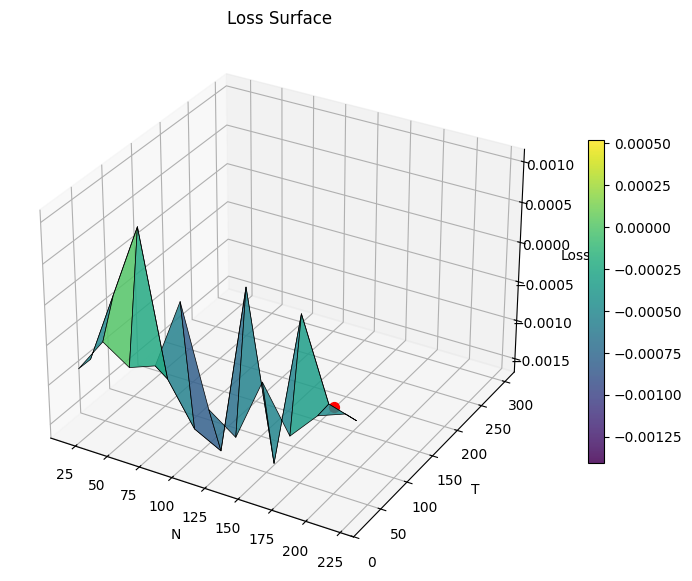

In [18]:
# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")
ax.scatter(200, 50, loss_grid[10,1], color='red', s=50)

fig.colorbar(surf, shrink=0.6)
plt.savefig('images/loss_surface.png')
plt.show()

### out of sample comparaison 2

In [19]:
batch_size_oos = 1024

In [60]:
dataset = real_data_pipeline(
    batch_size_oos,
    date_bounds=('1995-01-01','2015-01-01'),
    n_days_out = T+10,
    n_days_in = T,
    shift = 0,
    n_stocks = n_stocks,
    market_cap_range = (1000, 3000),
    sequential = False,
    return_generator = False,
)

In [61]:
is_real_data=True

In [68]:
input_seq_cov_miss, Q_emp_cov_miss, R_oos, T, Tmin, Tmax, input_seq_cov_no_miss, Q_emp_cov_no_miss, lam_QIS, Q_QIS = next(data_generator_2types(batch_size_oos, N_min=200, N_max=200, T_min=50, T_max=50, real_data=is_real_data, dataset=dataset))

In [ ]:
lam_emp_miss     = input_seq_cov_miss[:, :, 0]
lam_emp_no_miss  = input_seq_cov_no_miss[:, :, 0]
lam_pred_miss    = model_real_data(input_seq_cov_miss)
lam_pred_no_miss = model_real_data(input_seq_cov_no_miss)

Comparaison eigenvalues $\lambda$ (what matters)

In [ ]:
loss_pred_lam_miss    = - loss_function_portfolio(lam_emp_miss, Q_emp_cov_miss, R_oos, T)
loss_pred_lam_no_miss = - loss_function_portfolio(lam_emp_no_miss, Q_emp_cov_no_miss, R_oos, T)
loss_lam_miss         = - loss_function_portfolio(lam_pred_miss, Q_emp_cov_miss, R_oos, T)
loss_lam_no_miss      = - loss_function_portfolio(lam_pred_no_miss, Q_emp_cov_no_miss, R_oos, T)
loss_lam_QIS          = - loss_function_portfolio(lam_QIS, Q_emp_cov_no_miss, R_oos, T)

# mse_noisy_test_lam
# mse_shaffer_test_lam = mse(lam_true_oos, lam_emp_1_oos.squeeze(-1))


print(f"Portfolio profit after miss + NN:         {loss_pred_lam_miss:.6f}")
print(f"Portfolio profit after no miss + NN :     {loss_pred_lam_no_miss:.6f}")
print(f"Portfolio profit after miss + no NN :     {loss_lam_miss:.6f}")
print(f"Portfolio profit after no miss  + no NN : {loss_lam_no_miss:.6f}")
print(f"Portfolio profit after no miss QIS :      {loss_lam_QIS:.6f}")

# print(f"MSE Shaffer  : {mse_shaffer_test_lam:.6f}")

Portfolio profit after miss + NN:         0.000308
Portfolio profit after no miss + NN :     0.010615
Portfolio profit after miss + no NN :     0.000560
Portfolio profit after no miss  + no NN : 0.000560
Portfolio profit after no miss QIS :      0.000550


Graphique : 

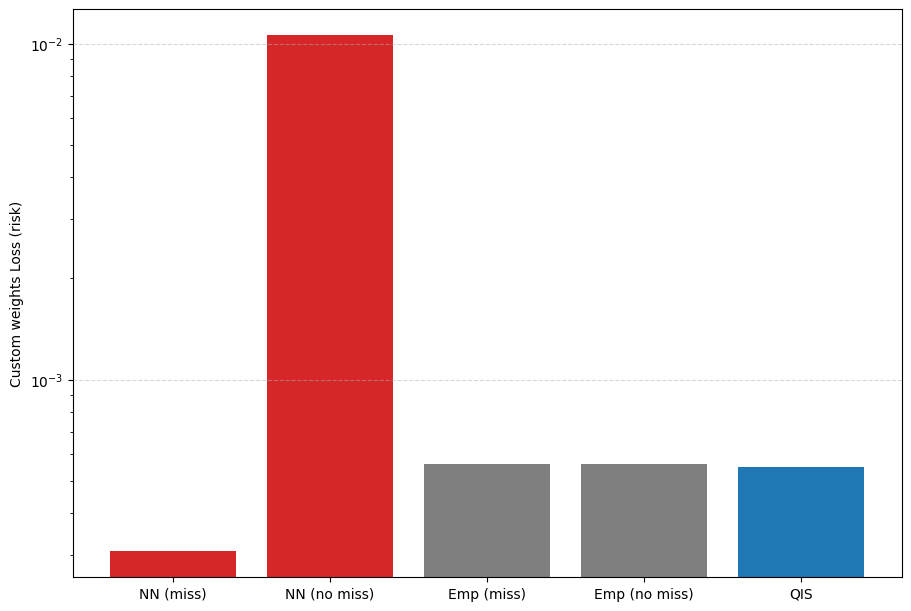

In [67]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)', 'QIS']
values = [loss_pred_lam_miss.item(), loss_pred_lam_no_miss.item(), loss_lam_miss.item(), loss_lam_no_miss.item(), loss_lam_QIS.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray','tab:blue']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('Custom weights Loss (risk)')
plt.grid(axis='y', ls='--', alpha=.5)
plt.show()


We except this on generated data

- remove comparaison with trace : if necessary it can be normalized at the output of our network $\lambda_j * N / \sum_{i=1}^{N}\lambda_i $
- remove comparaison with eigenvalues : not meaning full as they are in another base !

### BackTesting / Trying on real data

Covariances depend on scale

Correlations are scale-invariant $\rho_{ij} = \frac{\Sigma_{ij}}{\sigma_i \sigma_j + \epsilon_i}$

=> should we then learn on correlation instead of covariance

Some stocks do not move at all over 10 days  
- variance = 0  
- correlation = NaN  


Should the distance to Sigma_true be replaced by the distance to $\Sigma_{nomiss \quad QIS}$ ?

2 means for the comparaison : 
- compute estimated revenu on oos sample following in sample
- compute distance with a matrix

In [33]:
is_real_data = True

In [47]:
input_seq_cov_miss, Q_emp_cov_miss, R_oos, T, Tmin, Tmax, input_seq_cov_no_miss, Q_emp_cov_no_miss, lam_QIS, Q_QIS = next(data_generator_2types(batch_size_oos, N_min=200, N_max=200, T_min=50, T_max=50, real_data=is_real_data, dataset=dataset))

#### Compute estimated revenu on oos sample following in sample

Say you have $R = (r_0, ..., r_T)$ and $R_{oos} = (r_0, ..., r_T, ... ,r_{T+10})$  
From R with missing values you compute $\Sigma_hat$, and then compute $w = \frac{\hat{\Sigma}^{-1} \mathbb{1}}{\mathbb{1}^T\hat\Sigma\mathbb{1}}$   
We set when NaNs are ...
Then compute $P_{oos} = w^T(r_{T+1} ... r_{T+10})$ Then sum and you get the expected return for the next d (=10 here) days  

To better compare we have many way of compute $\Sigma$
- with no data missingness
    - $\Sigma_{QIS}$
    - $\Sigma_{NN}$
    - $\Sigma_{cov}$
    - Nearest covariance matrix ?
- with data missingness
    - $\Sigma_{NN}$
    - $\Sigma_{cov}$

Shouldn't we train on real data instead of simulated data and we should work on minimizing that latter loss (we aim at maximizing the profit) ?  

What loss to use ? I try to maximize the profit for now switch to $n w^T \Sigma_{oos} w$

Question on $\Sigma_{oos}$

In [48]:
lam_pred_miss  = model_real_data(input_seq_cov_miss)
lam_pred_no_miss  = model_real_data(input_seq_cov_no_miss)
lam_emp_cov_miss = input_seq_cov_miss[:,:,0]
lam_emp_cov_no_miss = input_seq_cov_no_miss[:,:,0]

In [49]:
Sigma_pred_miss    = reconstruct_cov(Q_emp_cov_miss, lam_pred_miss)
Sigma_pred_no_miss = reconstruct_cov(Q_emp_cov_no_miss, lam_pred_no_miss)
Sigma_emp_miss     = reconstruct_cov(Q_emp_cov_miss, lam_emp_cov_miss)
Sigma_emp_no_miss  = reconstruct_cov(Q_emp_cov_no_miss, lam_emp_cov_no_miss)
Sigma_QIS          = reconstruct_cov(Q_QIS, lam_QIS)

In [50]:
ones = torch.ones(batch_size, n_stocks,1)

In [51]:
w_pred_miss       = torch.linalg.solve(Sigma_pred_miss, ones)/torch.linalg.solve(Sigma_pred_miss, ones).sum(dim=1, keepdim=True)
w_pred_no_miss    = torch.linalg.solve(Sigma_pred_no_miss, ones)/torch.linalg.solve(Sigma_pred_no_miss, ones).sum(dim=1, keepdim=True)
w_emp_cov_miss    = torch.linalg.solve(Sigma_emp_miss, ones)/torch.linalg.solve(Sigma_emp_miss, ones).sum(dim=1, keepdim=True)
w_emp_cov_no_miss = torch.linalg.solve(Sigma_emp_no_miss, ones)/torch.linalg.solve(Sigma_emp_no_miss, ones).sum(dim=1, keepdim=True)
w_QIS             = torch.linalg.solve(Sigma_QIS, ones)/torch.linalg.solve(Sigma_QIS, ones).sum(dim=1, keepdim=True)

In [52]:
P_pred_miss       = torch.mean(torch.sum(w_pred_miss.transpose(1,2) @ R_oos, dim=2)).item()
P_pred_no_miss    = torch.mean(torch.sum(w_pred_no_miss.transpose(1,2) @ R_oos, dim=2)).item()
P_emp_cov_miss    = torch.mean(torch.sum(w_emp_cov_miss.transpose(1,2) @ R_oos, dim=2)).item()
P_emp_cov_no_miss = torch.mean(torch.sum(w_emp_cov_no_miss.transpose(1,2) @ R_oos, dim=2)).item()
P_QIS             = torch.mean(torch.sum(w_QIS.transpose(1,2) @ R_oos, dim=2)).item()

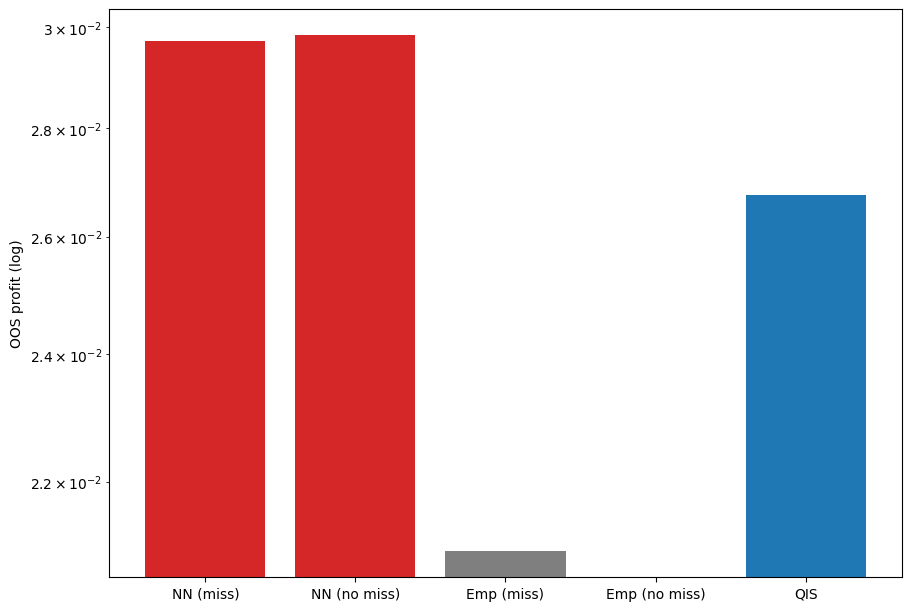

In [53]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)', 'QIS']
values = [P_pred_miss, P_pred_no_miss, P_emp_cov_miss, P_emp_cov_no_miss, P_QIS]
colors = ['tab:red','tab:red','tab:gray','tab:gray','tab:blue']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('OOS profit (log)')
plt.grid(axis='y', ls='--', alpha=.5)
plt.show()


depending on the batch it doesn't work at all, how is the real_dataloader made with its sampler ? 

#### Compute distance with a matrix

As $\Sigma_{QIS}$ is supposed to be equal to the real covariance matrix we can compute all the comparaison on this matrix

### Add hyperparameter selection

### Loss that minimizes the Portfolio Risk